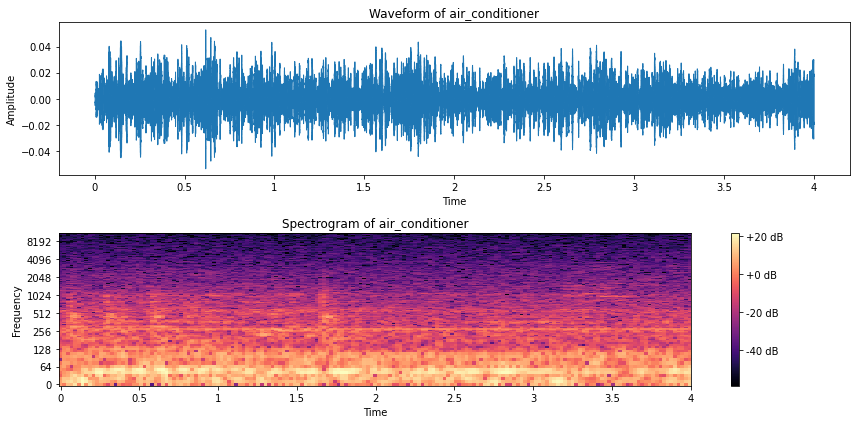

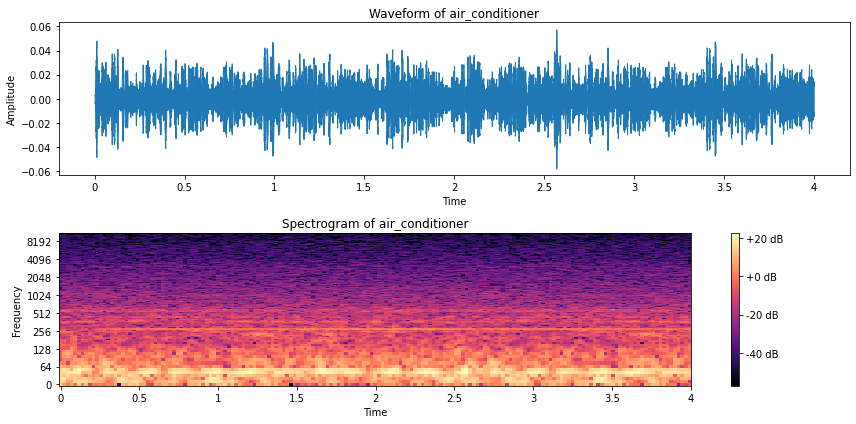

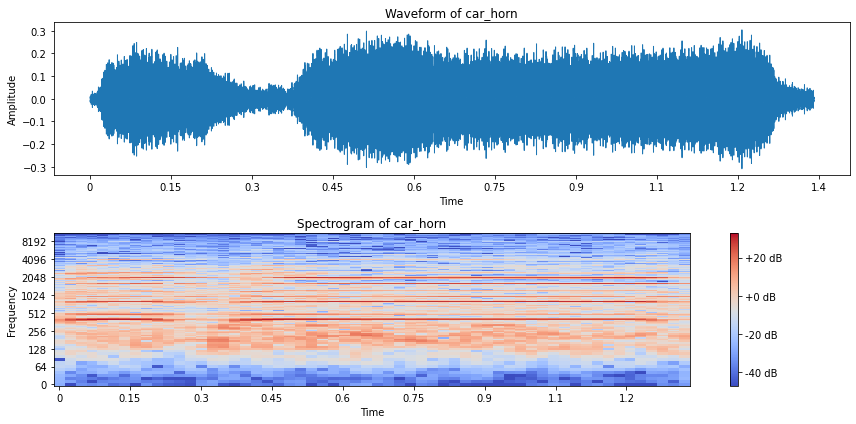

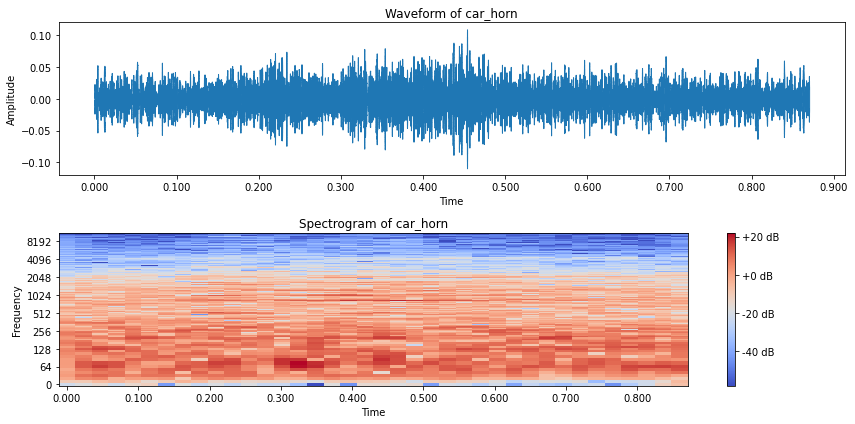

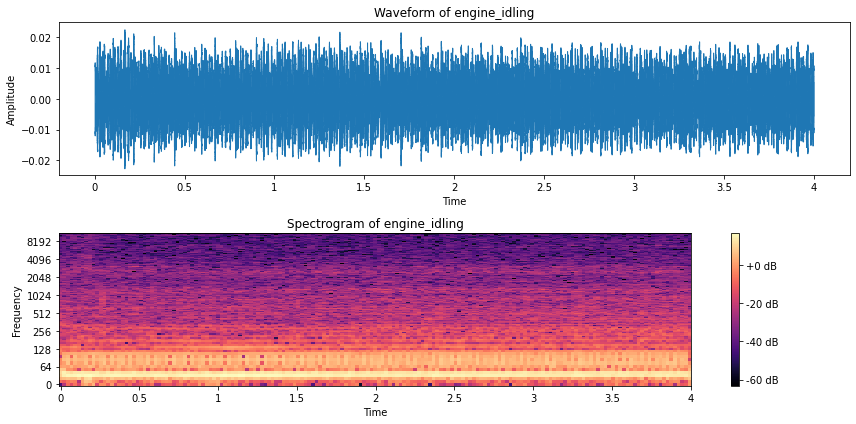

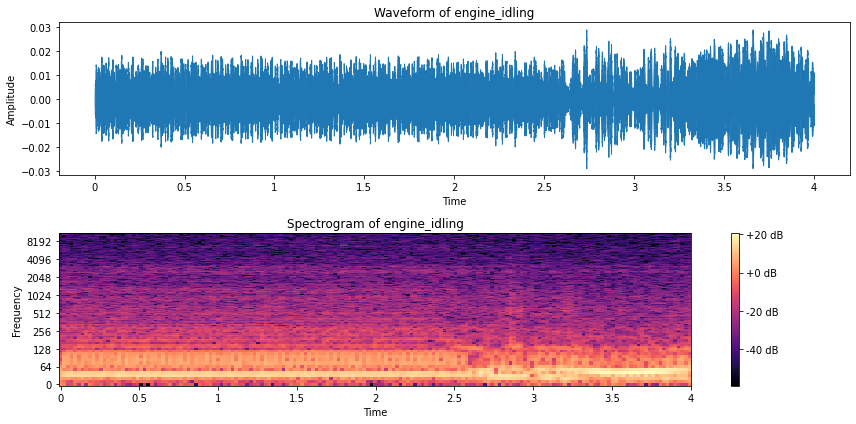

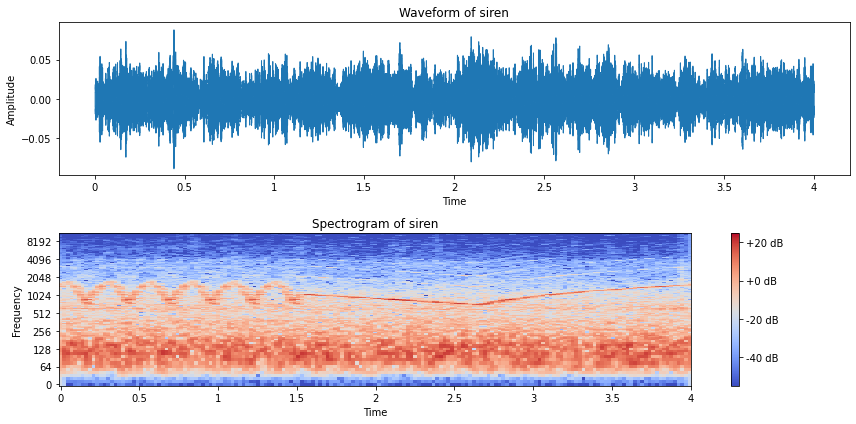

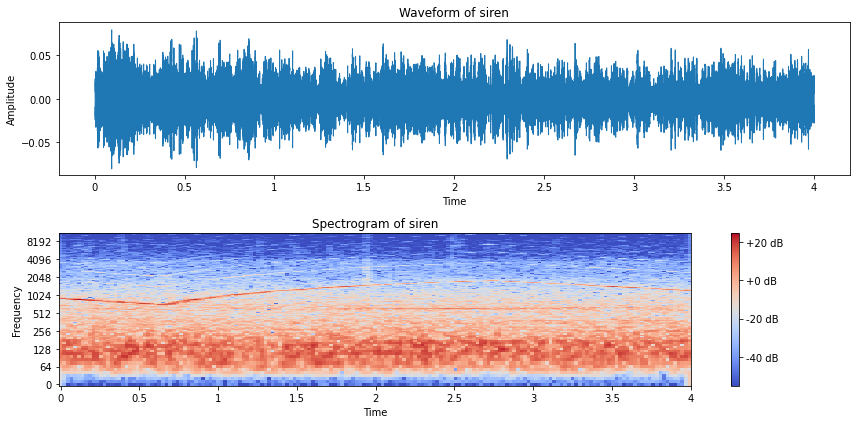

In [5]:
import os
import numpy as np
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to data folders
data_folders = {
    'air_conditioner': 'E:/Synopsys_Data_Challenge/data/air_conditioner',
    'car_horn': 'E:/Synopsys_Data_Challenge/data/car_horn',
    'engine_idling': 'E:/Synopsys_Data_Challenge/data/engine_idling',
    'siren': 'E:/Synopsys_Data_Challenge/data/siren'
}

def plot_waveforms_and_spectrograms(file_path, label):
    audio, sr = librosa.load(file_path)
    
    plt.figure(figsize=(12, 6))

    # Plot waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f'Waveform of {label}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Plot spectrogram
    plt.subplot(2, 1, 2)
    stft = librosa.stft(audio)
    stft_db = librosa.amplitude_to_db(abs(stft))
    librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='log')
    plt.title(f'Spectrogram of {label}')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Loop through each class folder and plot the waveforms and spectrograms for a few files
for class_name, class_dir in data_folders.items():
    files = os.listdir(class_dir)[:2]  # Taking first 2 files for visualization
    
    for file in files:
        file_path = os.path.join(class_dir, file)
        plot_waveforms_and_spectrograms(file_path, class_name)


Linear SVM Classification Report:
                 precision    recall  f1-score   support

air_conditioner       1.00      1.00      1.00        10
       car_horn       0.80      0.67      0.73         6
  engine_idling       0.89      0.89      0.89         9
          siren       0.88      1.00      0.93         7

       accuracy                           0.91        32
      macro avg       0.89      0.89      0.89        32
   weighted avg       0.90      0.91      0.90        32

Random Forest Classification Report:
                 precision    recall  f1-score   support

air_conditioner       1.00      1.00      1.00        10
       car_horn       1.00      0.83      0.91         6
  engine_idling       1.00      1.00      1.00         9
          siren       0.88      1.00      0.93         7

       accuracy                           0.97        32
      macro avg       0.97      0.96      0.96        32
   weighted avg       0.97      0.97      0.97        32



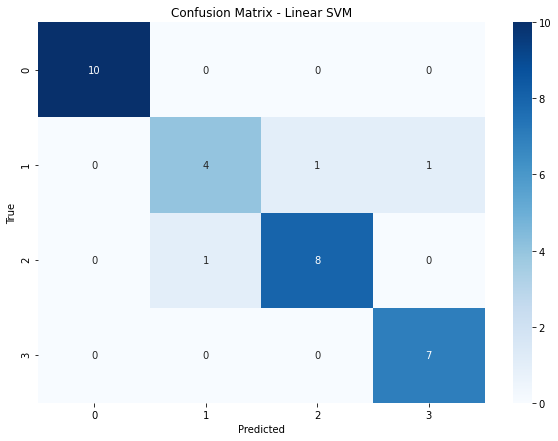

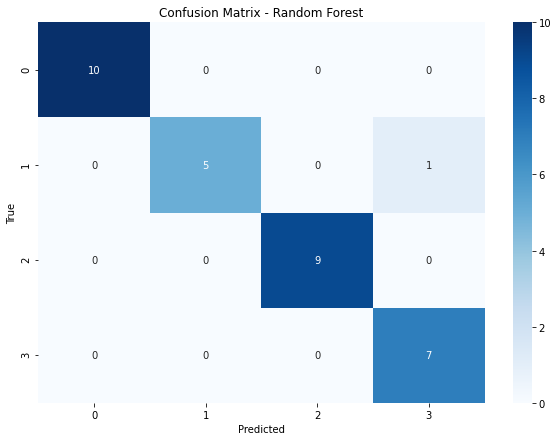

In [6]:
# Function to load audio files and extract labels
def load_audio_files(data_folders):
    X, y = [], []
    for label, folder in data_folders.items():
        for file in os.listdir(folder):
            if file.endswith('.wav'):
                filepath = os.path.join(folder, file)
                audio, sr = librosa.load(filepath, sr=None)
                X.append(audio)
                y.append(label)
    return X, y

# Load audio files
X, y = load_audio_files(data_folders)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction function
def extract_features(audio, sr):
    n_fft = min(2048, len(audio) // 2)
    n_mels = max(13, n_fft // 2 // 10)
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=n_fft, n_mels=n_mels)
    mfccs = np.mean(mfccs.T, axis=0)
    
    zcr = np.mean(librosa.feature.zero_crossing_rate(audio))                           
    
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    
    return np.hstack([mfccs, zcr, spectral_centroid])

# Extract features for training and testing sets
X_train_features = np.array([extract_features(audio, sr=44100) for audio in X_train])
X_test_features = np.array([extract_features(audio, sr=44100) for audio in X_test])

# Standardize the features
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

# Train a linear SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_features, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test_features)

# Evaluate the model
print("Linear SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Train a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_features, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_features)

# Evaluate the model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Confusion matrix for SVM
plot_confusion_matrix(y_test, y_pred_svm, "Confusion Matrix - Linear SVM")

# Confusion matrix for Random Forest
plot_confusion_matrix(y_test, y_pred_rf, "Confusion Matrix - Random Forest")